# В данном ноутбуке решаем задачу сегментации дефектов на транспортерной ленте. Для этого импортируем ранее созданный датафрейм с разметкой и сами изображения.

Импортируем необходимые библиотеки

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import maskrcnn_resnet50_fpn
from PIL import Image
import numpy as np
import pandas as pd
from skimage.draw import polygon
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt

На основе информации о точках вершин полигонов определяем функцию создания масок объектов

In [ ]:
# Преобразование точек в маски
def points_to_mask(image_size, points):
    mask = np.zeros(image_size, dtype=np.uint8)
    for poly in points:
        rr, cc = polygon(poly[:, 1], poly[:, 0])
        mask[rr, cc] = 1
    return mask

Создаем пользовательский датасет для его дальнейшей обработки моделью

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, img_path):
        self.df = df
        self.img_path = img_path

    def __getitem__(self, idx):
        # Получим строку данных
        row = self.df.iloc[idx]

        # Загрузим изображение
        img_path = os.path.join(self.img_path, row['name'])
        image = np.array(Image.open(img_path))
        image = image / 255.0  # Нормализация изображения
        image = torch.as_tensor(image, dtype=torch.float32).permute(2, 0, 1)  # Преобразуем в формат [C, H, W]

        # Загрузим аннотации
        width = row['width']
        height = row['height']
        label = row['class']

        # Преобразуем точки в массив numpy
        points = [list(map(float, p.split(','))) for p in row['points'].split(';')]
        points = np.array(points).reshape(-1, 2)

        # Преобразуем точки в bounding boxes и masks
        boxes = []
        masks = []
        x_coords, y_coords = points[:, 0], points[:, 1]
        x_min, x_max = x_coords.min(), x_coords.max()
        y_min, y_max = y_coords.min(), y_coords.max()

        boxes.append([x_min, y_min, x_max, y_max])
        mask = points_to_mask((height, width), [points])
        masks.append(mask)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor([1], dtype=torch.int64)  # Замените 1 на ваше значение классов

        # Преобразуем список масок в один массив numpy перед преобразованием в тензор
        masks = np.array(masks)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        target = {"boxes": boxes, "labels": labels, "masks": masks}

        return image, target

    def __len__(self):
        return len(self.df)

Импортируем разметку объектов и изображения

In [ ]:
df = pd.read_csv('output.csv')  # загружаем датафрейм с разметкой
img_path = '/content/images'  # загружаем выборку изображений
dataset = CustomDataset(df, img_path)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

Создаем модель сегментации на основе MaskRCNN

In [ ]:
# Загрузка модели
weights = MaskRCNN_ResNet50_FPN_Weights.COCO_V1
model = maskrcnn_resnet50_fpn(weights=weights)

# Количество классов (например, 1 класс + фон)
num_classes = 3

# Замена box_predictor
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    model.roi_heads.box_predictor.cls_score.in_features, num_classes
)

# Замена mask_predictor
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
    model.roi_heads.mask_predictor.conv5_mask.in_channels,
    model.roi_heads.mask_predictor.conv5_mask.out_channels,
    num_classes
)

# Проверка модели
print(model)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 106MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

Определяем параметры оптимизатора модели

In [ ]:
# Оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Запускаем обучение модели на 3 эпохах (набор изображений не большой, поэтому обучение не долгое)

In [ ]:
# Обучение модели
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    for i, (images, targets) in enumerate(dataloader):
        images = list(image for image in images)
        targets = [{k: v for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Клипенг градиентов
        optimizer.step()

        if i % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {losses.item():.4f}')

Epoch [1/3], Loss: 6.2892
Epoch [1/3], Loss: 0.3050
Epoch [1/3], Loss: 0.1413
Epoch [1/3], Loss: 0.1991
Epoch [1/3], Loss: 0.1295
Epoch [1/3], Loss: 0.1442
Epoch [2/3], Loss: 0.1395
Epoch [2/3], Loss: 0.0932
Epoch [2/3], Loss: 0.1315
Epoch [2/3], Loss: 0.1863
Epoch [2/3], Loss: 0.1128
Epoch [2/3], Loss: 0.0886
Epoch [3/3], Loss: 0.0887
Epoch [3/3], Loss: 0.0832
Epoch [3/3], Loss: 0.1065
Epoch [3/3], Loss: 0.0998
Epoch [3/3], Loss: 0.0770
Epoch [3/3], Loss: 0.0697


Переводим обученную модель в режим проверки

In [ ]:
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

Определяем функцию для визуализации предсказанных моделью масок объектов на ихображениях

In [ ]:
# Функция для отрисовки предсказанных масок на изображениях
def draw_segmentation_map_1(image, pred):
    boxes = pred['boxes'].cpu().detach().numpy().astype(int)
    labels = pred['labels'].cpu().detach().numpy()
    scores = pred['scores'].cpu().detach().numpy()
    masks = pred['masks'].cpu().detach().numpy()

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    ax.imshow(image)

    for i in range(len(boxes)):
        if scores[i] > 0.5:  # Пороговое значение для отображения бокса и маски
            box = boxes[i]
            mask = masks[i, 0]
            ax.imshow(mask, alpha=0.5, cmap='jet')

            # Обрисовка бокса вокруг объекта
            ax.add_patch(plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], edgecolor='r', facecolor='none', lw=2))

    plt.axis('off')
    plt.show()

Загружаем тестовые изображения и визуализируем объекты на них

In [ ]:
test_images = ['/content/1 (237).jpg', '/content/3 (45).jpg']

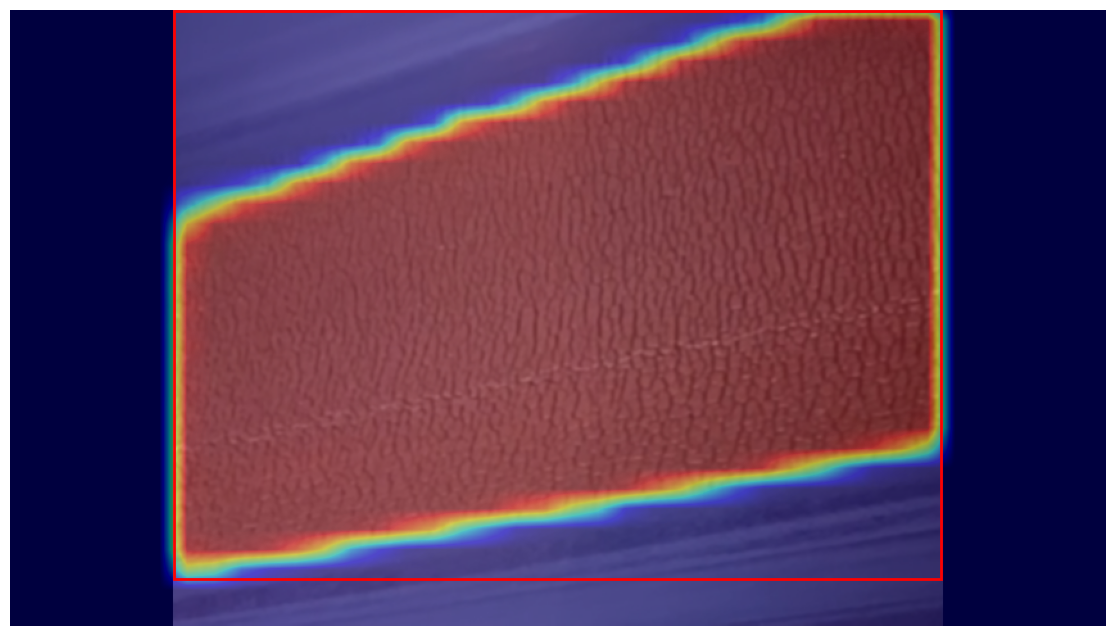

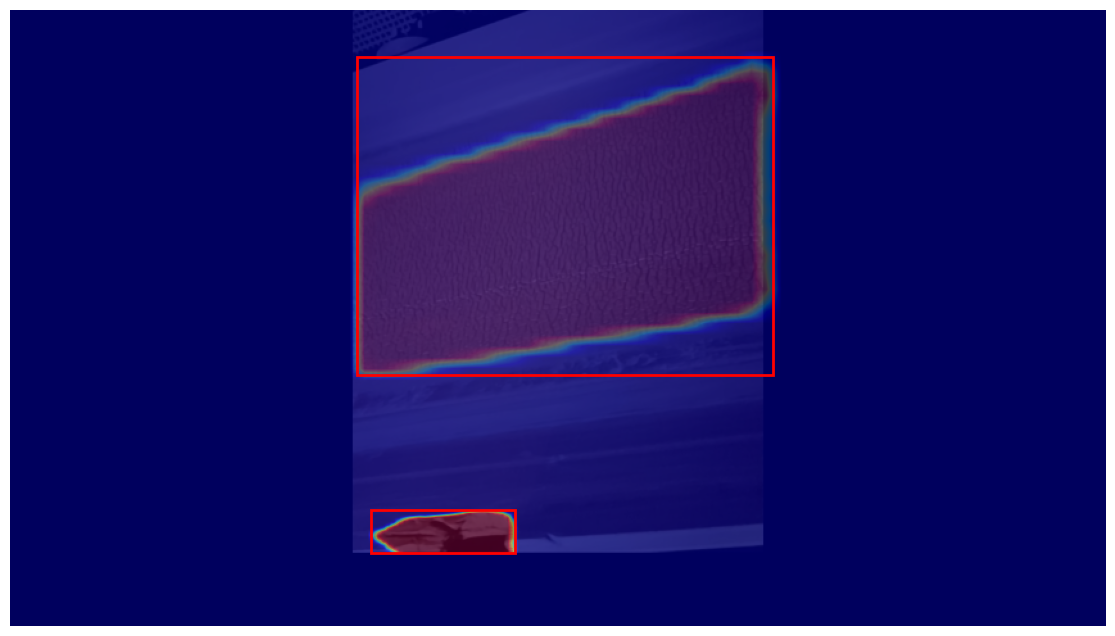

In [ ]:
for image_path in test_images:
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0)  # Преобразуем изображение в тензор
    with torch.no_grad():
        prediction = model(image_tensor)[0]
    draw_segmentation_map_1(image, prediction)

# Модель успешно находит не размеченные дефекты на ленте отрисовывая их границы на изображениях.
Сегментация дефектов на ленте расширяет возможности диагностики, позволяя более точно рассчитать площадь повреждения ленты и предсказать остаточный срок эксплуатации. Характер расположения объектов на изображении позволяет сделать вывод о причинах возникновения дефектов и разработать корректирующие мероприятия, исключив или ослабив их влияние.